In [2]:
%pip install -q -U datasets evaluate accelerate python-iso639

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.3/297.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━

Make sure to mouunt Google Drive at `/content/drive`

In [3]:
from dataclasses import dataclass, asdict
from typing import Any
import datetime
import sys

import datasets
import transformers
from transformers import AutoModel, Trainer, AutoModelForAudioClassification, TrainingArguments, AutoFeatureExtractor
from torch.utils.data import DataLoader
import torch
import evaluate
from tqdm.auto import trange, tqdm
import numpy as np
import iso639
import matplotlib.pyplot as plt

sys.path.append("/content/drive/MyDrive/ColabNotebooks")
import global_id_utils

In [4]:
timestamp_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_dir = "/content/drive/MyDrive/LangId Evaluation/minds-14_sanchit-ghandi-whisper-medium-fleurs-lang-id/" + timestamp_str + "/"

# Load model

In [5]:
model_id = "sanchit-gandhi/whisper-medium-fleurs-lang-id"
model = AutoModelForAudioClassification.from_pretrained(model_id)
# model.to_bettertransformer()
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/615M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

Create mappings to/from model ids to global ids to make using other datasets on this model easier. We create a common interface that allows translation to a single target.

In [6]:
# This model was trained in google/fleurs, so we can reuse the mappings from the dataset
# Copied from https://huggingface.co/datasets/google/fleurs/blob/main/fleurs.py
from collections import OrderedDict
FLEURS_LANG_TO_ID = OrderedDict([("Afrikaans", "af"), ("Amharic", "am"), ("Arabic", "ar"), ("Armenian", "hy"), ("Assamese", "as"), ("Asturian", "ast"), ("Azerbaijani", "az"), ("Belarusian", "be"), ("Bengali", "bn"), ("Bosnian", "bs"), ("Bulgarian", "bg"), ("Burmese", "my"), ("Catalan", "ca"), ("Cebuano", "ceb"), ("Mandarin Chinese", "cmn_hans"), ("Cantonese Chinese", "yue_hant"), ("Croatian", "hr"), ("Czech", "cs"), ("Danish", "da"), ("Dutch", "nl"), ("English", "en"), ("Estonian", "et"), ("Filipino", "fil"), ("Finnish", "fi"), ("French", "fr"), ("Fula", "ff"), ("Galician", "gl"), ("Ganda", "lg"), ("Georgian", "ka"), ("German", "de"), ("Greek", "el"), ("Gujarati", "gu"), ("Hausa", "ha"), ("Hebrew", "he"), ("Hindi", "hi"), ("Hungarian", "hu"), ("Icelandic", "is"), ("Igbo", "ig"), ("Indonesian", "id"), ("Irish", "ga"), ("Italian", "it"), ("Japanese", "ja"), ("Javanese", "jv"), ("Kabuverdianu", "kea"), ("Kamba", "kam"), ("Kannada", "kn"), ("Kazakh", "kk"), ("Khmer", "km"), ("Korean", "ko"), ("Kyrgyz", "ky"), ("Lao", "lo"), ("Latvian", "lv"), ("Lingala", "ln"), ("Lithuanian", "lt"), ("Luo", "luo"), ("Luxembourgish", "lb"), ("Macedonian", "mk"), ("Malay", "ms"), ("Malayalam", "ml"), ("Maltese", "mt"), ("Maori", "mi"), ("Marathi", "mr"), ("Mongolian", "mn"), ("Nepali", "ne"), ("Northern-Sotho", "nso"), ("Norwegian", "nb"), ("Nyanja", "ny"), ("Occitan", "oc"), ("Oriya", "or"), ("Oromo", "om"), ("Pashto", "ps"), ("Persian", "fa"), ("Polish", "pl"), ("Portuguese", "pt"), ("Punjabi", "pa"), ("Romanian", "ro"), ("Russian", "ru"), ("Serbian", "sr"), ("Shona", "sn"), ("Sindhi", "sd"), ("Slovak", "sk"), ("Slovenian", "sl"), ("Somali", "so"), ("Sorani-Kurdish", "ckb"), ("Spanish", "es"), ("Swahili", "sw"), ("Swedish", "sv"), ("Tajik", "tg"), ("Tamil", "ta"), ("Telugu", "te"), ("Thai", "th"), ("Turkish", "tr"), ("Ukrainian", "uk"), ("Umbundu", "umb"), ("Urdu", "ur"), ("Uzbek", "uz"), ("Vietnamese", "vi"), ("Welsh", "cy"), ("Wolof", "wo"), ("Xhosa", "xh"), ("Yoruba", "yo"), ("Zulu", "zu")])
FLEURS_LANG_SHORT_TO_LONG = {v: k for k, v in FLEURS_LANG_TO_ID.items()}

In [7]:
model_id_to_global_id = {
    model_id: global_id_utils.language_to_global_id(FLEURS_LANG_TO_ID[model.config.id2label[model_id]].split("_")[0])
    for model_id in model.config.id2label
}

In [8]:
global_id_to_model_id = {v:k for k, v in model_id_to_global_id.items()}

# Load and preprocess data

In [9]:
# On Google Colab cpu, runs at about 0.04 it/s, so 200 will over 1.25 hours
minds_14 = datasets.load_dataset("PolyAI/minds14", "all", split="train").shuffle(seed=42).select(range(25))
minds_14

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 25
})

The label names in minds14 are ISO 639-1 codes with the locale (country) afterwards, separated by a hyphen ("en-us"). We take just the language code and use that to create the global id.

The label for Chinese Mandarin in `minds14` is "zh" while the label in `whipser-medium-fleurs-lang-id` is "cmn". Add a custom mapping to fix that discrepency.

In [10]:
minds_int2str = minds_14.features["lang_id"]._int2str
minds_str2int = minds_14.features["lang_id"]._str2int

In [11]:
dataset_id_to_global_id = {
    dataset_id: global_id_utils.iso639_part3_to_global_id(
        iso639.Language.from_part1(minds_int2str[dataset_id].split("-")[0]).part3)
    for dataset_id in minds_14.features["lang_id"]._str2int.values()
}
dataset_id_to_global_id[minds_str2int["zh-CN"]] = global_id_utils.iso639_part3_to_global_id("cmn")

Verify that all dataset languages map to a language in the model.

In [12]:
for name in minds_14.features["lang_id"].names:
  dataset_id = minds_14.features["lang_id"]._str2int[name]
  global_id = dataset_id_to_global_id[dataset_id]
  if global_id not in global_id_to_model_id:
    print(f"Warning: The language {name} (id {dataset_id}) in the dataset does not map to an id in the model."
    + "\nAdd a custom entry to the global_id_to_model_id dictionary")

In [13]:
minds_14 = minds_14.remove_columns(["path", "transcription", "english_transcription", "intent_class"])

In [14]:
minds_14 = minds_14.cast_column("audio", datasets.Audio(sampling_rate=16000))

In [15]:
def preprocess(sample):
  new_sample = feature_extractor(sample["audio"]["array"], sampling_rate=16_000, return_tensors="pt")
  new_sample["input_features"] = torch.squeeze(new_sample["input_features"])
  global_id = dataset_id_to_global_id[sample["lang_id"]]
  new_sample["label"] = global_id_to_model_id[global_id]
  return new_sample

In [16]:
minds_14 = minds_14.map(preprocess, batched=False, remove_columns=["audio"])

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

In [17]:
accuracy = evaluate.load("accuracy")

In [18]:
def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    return acc

In [19]:
sample = next(iter(minds_14))
sample.keys()

dict_keys(['lang_id', 'input_features', 'label'])

# Make inferences

In [20]:
args = TrainingArguments(
    output_dir=output_dir,
    per_device_eval_batch_size=1,
    logging_steps=25,
)

In [21]:
trainer = Trainer(
    args=args,
    model=model,
    eval_dataset=minds_14,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [22]:
# eval_results = trainer.evaluate()
# eval_results

In [23]:
%%time
prediction_output = trainer.predict(minds_14)
prediction_output

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:4193: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/modeling_whisper.py:1165: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if input_features.shape[-1] != expected_seq_length:
/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/modeling_whisper.py:707: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize t

CPU times: user 13min 52s, sys: 18.9 s, total: 14min 11s
Wall time: 14min 26s


PredictionOutput(predictions=array([[-2.084059  ,  0.07463838,  1.2860639 , ..., -0.0558261 ,
        -0.08016056, -0.09301612],
       [-1.9898582 ,  0.3053639 ,  1.5508051 , ...,  0.6920784 ,
        -1.6692082 , -1.3006887 ],
       [ 1.7096027 , -0.23260143,  1.0263451 , ..., -0.4569441 ,
         0.19102758, -3.120585  ],
       ...,
       [ 0.14066881,  0.1865752 , -1.3821777 , ...,  0.21637458,
        -1.3888863 , -0.8045373 ],
       [-0.6850002 ,  1.3378315 ,  1.7180492 , ..., -0.00493166,
         1.0919114 , -1.0680517 ],
       [-2.7072031 ,  2.129237  ,  2.6184387 , ...,  2.1366587 ,
         0.11446661, -0.61382467]], dtype=float32), label_ids=array([39, 39, 78, 26, 19, 74, 67, 14, 19, 17, 74, 19, 76, 26, 13, 76, 19,
       78, 19, 48, 78, 26, 19, 17, 26]), metrics={'test_loss': 2.822765588760376, 'test_jit_compilation_time': 196.4613, 'test_accuracy': 0.64, 'test_runtime': 670.1452, 'test_samples_per_second': 0.037, 'test_steps_per_second': 0.037})

# Evaluate

In [24]:
import eval_report

In [25]:
prediction_model_ids = np.argmax(prediction_output.predictions, axis=-1)
label_model_ids = prediction_output.label_ids

In [26]:
np.unique(label_model_ids)

array([13, 14, 17, 19, 26, 39, 48, 67, 74, 76, 78])

In [27]:
np.unique(prediction_model_ids)

array([ 7, 13, 14, 17, 19, 26, 27, 39, 48, 56, 73, 74, 78])

In [28]:
model.config.id2label[7]

'Bulgarian'

In [29]:
[model.config.id2label[id] for id in np.unique(prediction_model_ids)]

['Bulgarian',
 'Mandarin Chinese',
 'Czech',
 'German',
 'English',
 'French',
 'Irish',
 'Italian',
 'Korean',
 'Latvian',
 'Punjabi',
 'Polish',
 'Russian']

In [30]:
import importlib

In [31]:
importlib.reload(eval_report)

<module 'eval_report' from '/content/drive/MyDrive/ColabNotebooks/eval_report.py'>

In [32]:
prediction_model_ids, label_model_ids, unique_prediction_ids, unique_prediction_labels = eval_report.unique_prediction_ids_and_labels(prediction_output, model.config.id2label)

In [33]:
prediction_model_ids

array([39, 39, 78, 26, 19, 78, 56, 14, 27, 17, 74, 27,  7, 73, 13, 27, 27,
       78, 27, 48, 78, 26, 19, 17, 26])

In [34]:
label_model_ids

array([39, 39, 78, 26, 19, 74, 67, 14, 19, 17, 74, 19, 76, 26, 13, 76, 19,
       78, 19, 48, 78, 26, 19, 17, 26])

In [35]:
prediction_names = [model.config.id2label[id] for id in prediction_model_ids]
prediction_names

['Italian',
 'Italian',
 'Russian',
 'French',
 'English',
 'Russian',
 'Latvian',
 'Czech',
 'Irish',
 'German',
 'Polish',
 'Irish',
 'Bulgarian',
 'Punjabi',
 'Mandarin Chinese',
 'Irish',
 'Irish',
 'Russian',
 'Irish',
 'Korean',
 'Russian',
 'French',
 'English',
 'German',
 'French']

In [36]:
label_names = [model.config.id2label[id] for id in label_model_ids]
label_names

['Italian',
 'Italian',
 'Russian',
 'French',
 'English',
 'Polish',
 'Dutch',
 'Czech',
 'English',
 'German',
 'Polish',
 'English',
 'Portuguese',
 'French',
 'Mandarin Chinese',
 'Portuguese',
 'English',
 'Russian',
 'English',
 'Korean',
 'Russian',
 'French',
 'English',
 'German',
 'French']

In [37]:
unique_label_ids = np.unique(label_model_ids)
unique_label_names = [model.config.id2label[id] for id in unique_label_ids]

In [38]:
_, report_text = eval_report.save_report(output_dir, label_model_ids, prediction_model_ids, unique_label_ids, unique_label_names)
print(report_text)

                  precision    recall  f1-score   support

Mandarin Chinese       1.00      1.00      1.00         1
           Czech       1.00      1.00      1.00         1
          German       1.00      1.00      1.00         2
         English       1.00      0.33      0.50         6
          French       1.00      0.75      0.86         4
         Italian       1.00      1.00      1.00         2
          Korean       1.00      1.00      1.00         1
           Dutch       0.00      0.00      0.00         1
          Polish       1.00      0.50      0.67         2
      Portuguese       0.00      0.00      0.00         2
         Russian       0.75      1.00      0.86         3

       micro avg       0.94      0.64      0.76        25
       macro avg       0.80      0.69      0.72        25
    weighted avg       0.85      0.64      0.69        25



/content/drive/MyDrive/ColabNotebooks/eval_report.py:65: RuntimeWarning: invalid value encountered in divide
  accuracy = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]


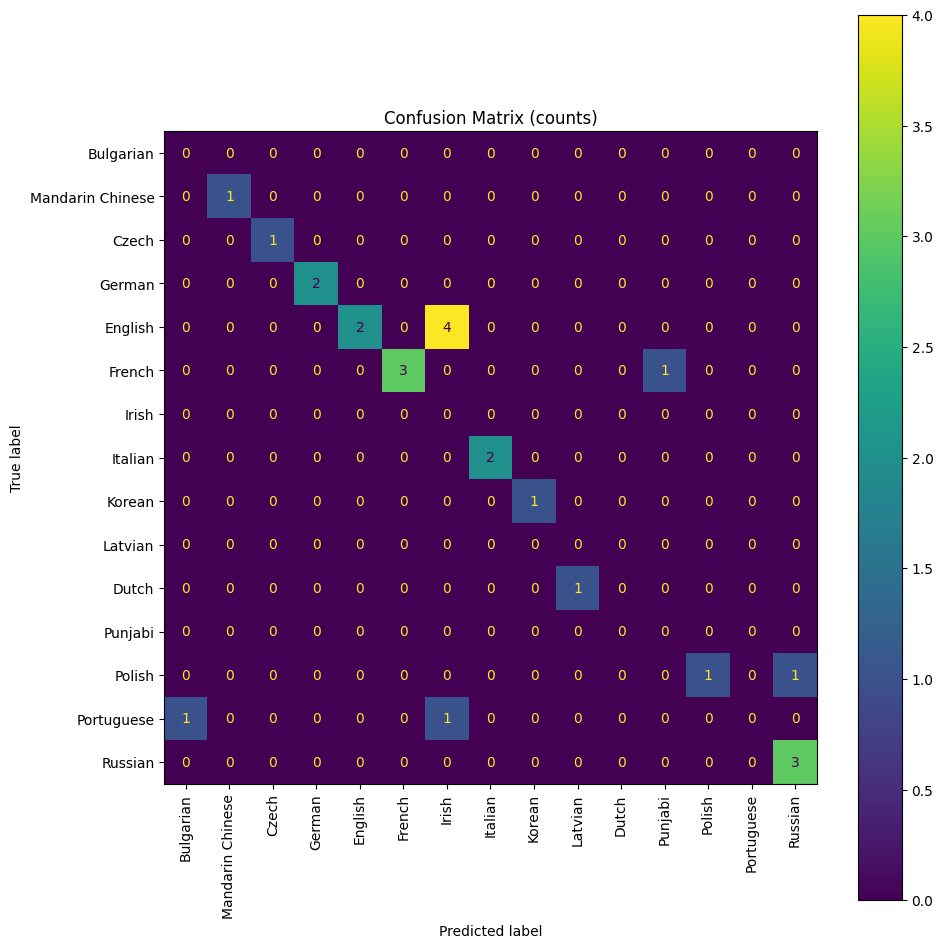

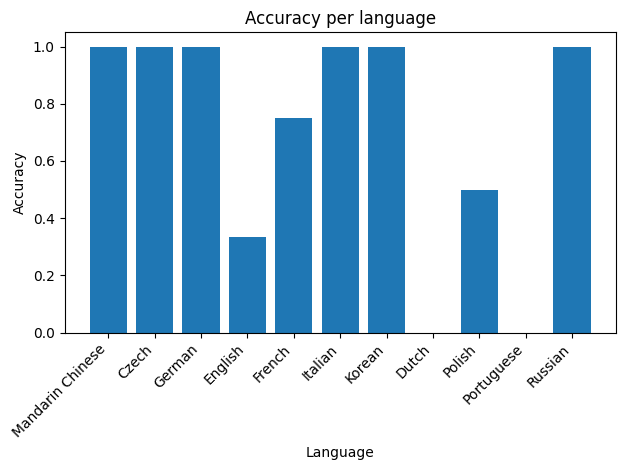

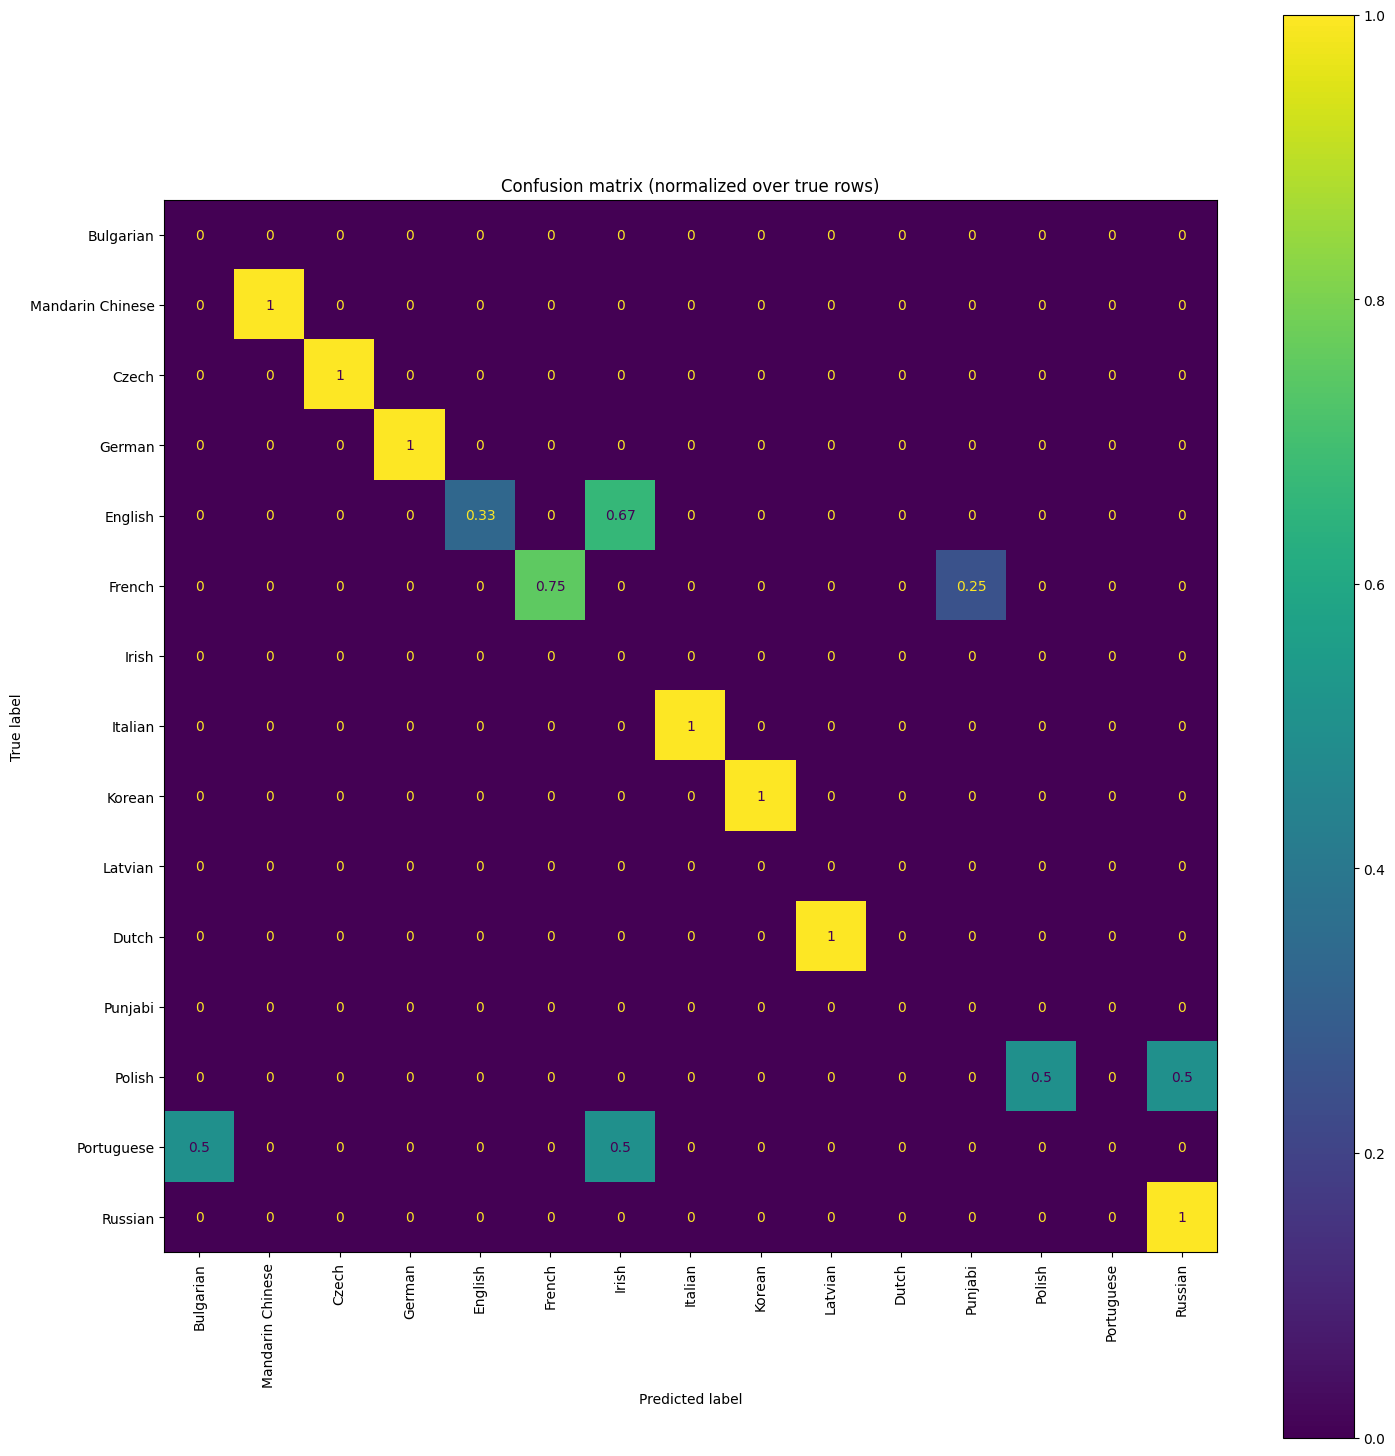

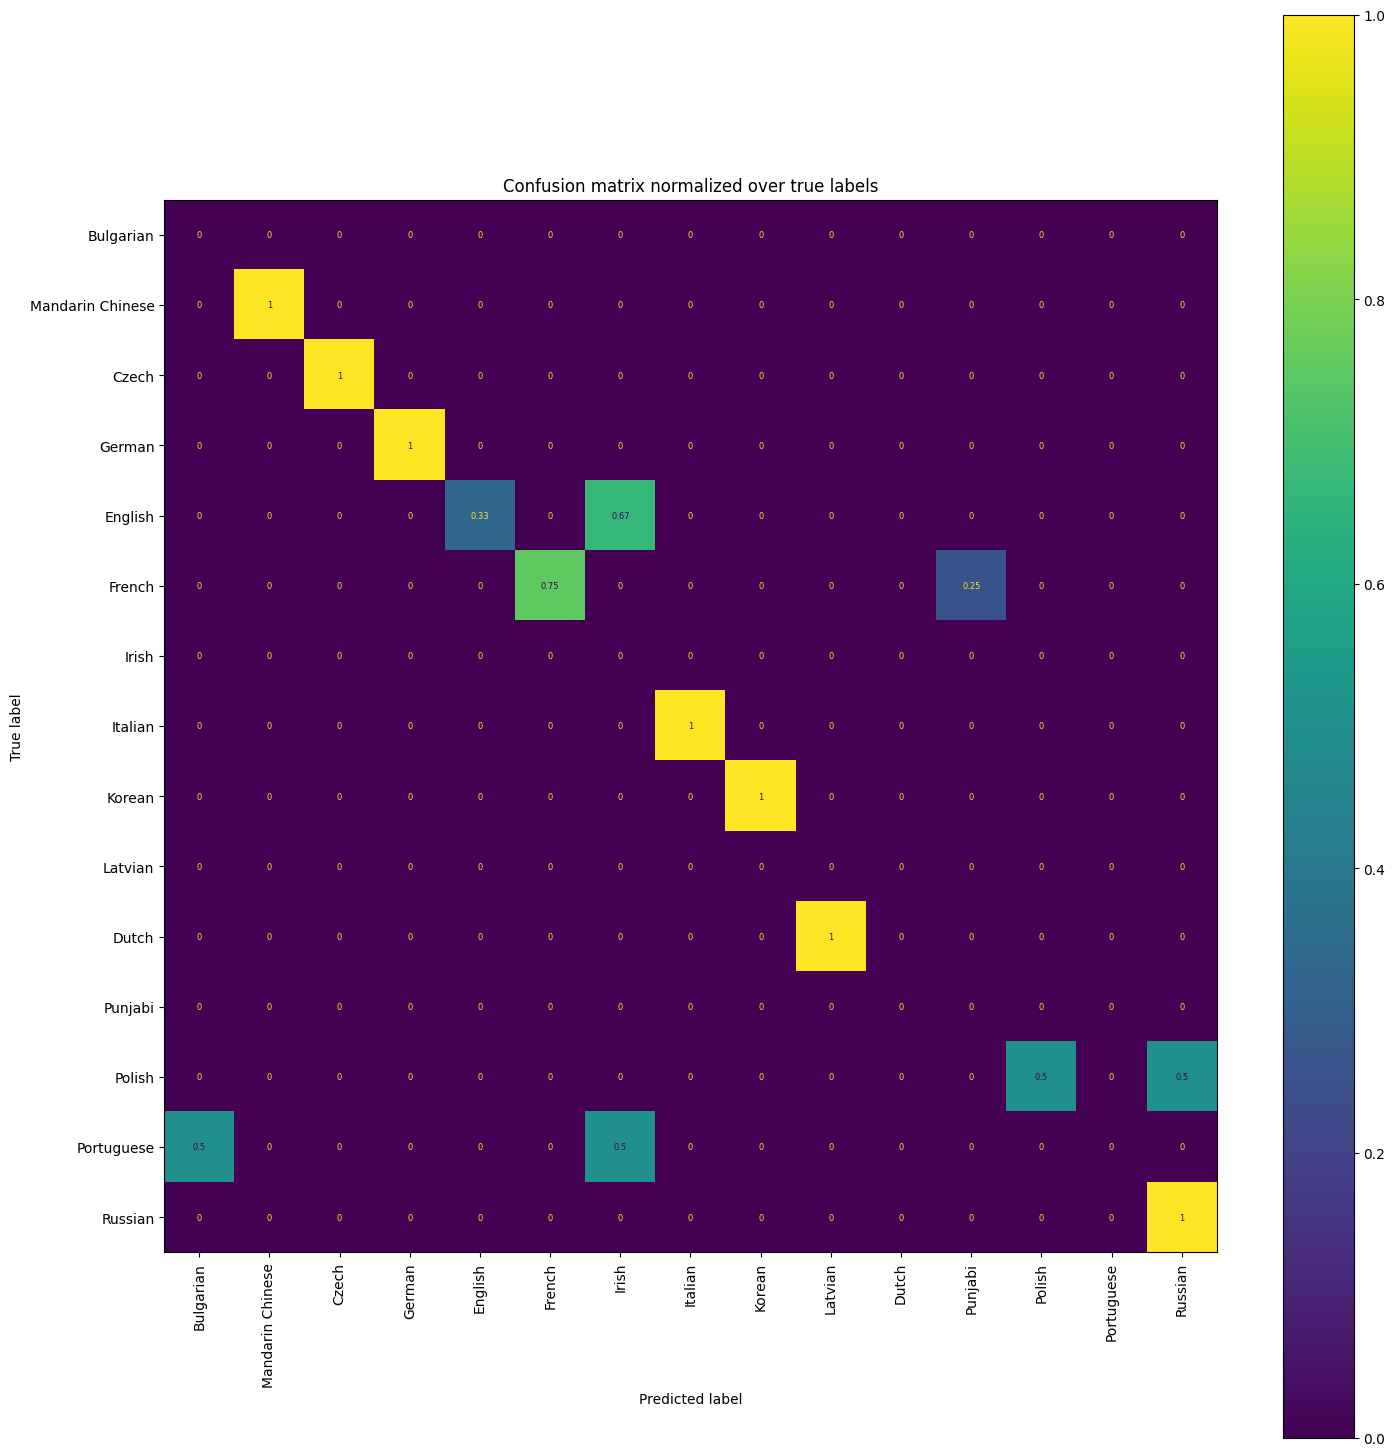

In [39]:
eval_report.create_and_save_visualizations(output_dir, label_model_ids, prediction_model_ids, model.config.id2label)

In [40]:
eval_report.save_predictions(output_dir, prediction_model_ids, label_model_ids, model_id_to_global_id)

In [41]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  2
  On-line CPU(s) list:   0,1
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:          6
    Model:               79
    Thread(s) per core:  2
    Core(s) per socket:  1
    Socket(s):           1
    Stepping:            0
    BogoMIPS:            4399.99
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clf
                         lush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_
                         good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fm
                         a cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hyp
                         ervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd i